In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchsummary import summary
from torchvision import transforms, datasets
from helper import fn_plot_torch_hist, fn_plot_confusion_matrix, fn_plot_torch_hist

C:\Users\duasp\AppData\Roaming\Python\Python311\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
inpDir = os.path.join( '..', 'input')


###moduleDir = 'MACHINE LEARNING'

outDir = os.path.join('output')
modelDir = 'Neural Network'
subDir = 'cifar10'
altName = 'pt_all_in'

# define and set random state 
RANDOM_STATE = 24
#np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

ALPHA = 0.001     # learning rate
EPOCHS = 50
BATCH_SIZE = 32

IMG_WIDTH = 32
IMG_HEIGHT = 32

PATIENCE = 20
LR_PATIENCE = 10
LR_FACTOR = 0.1

EPSILON = 1e-8      # min significant difference


# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large',
          'savefig.dpi': 150,
          'image.cmap': 'jet',
          'image.interpolation': 'none',
          'savefig.bbox' : 'tight',
          'lines.linewidth' : 2,
          'legend.numpoints' : 1
         }
CMAP = plt.cm.rainbow
plt.rcParams.update(params);
plt.set_cmap(CMAP);
plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

TEST_SIZE=0.2

np.set_printoptions(precision=3, suppress=True)

pd.set_option("display.max_columns", 8)
pd.set_option('display.precision', 2)

__all__ = ['np', 'display', 'plt', 'pd', 'sklearn', 'seaborn']

<Figure size 1500x600 with 0 Axes>

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.version.cuda

'11.7'

In [5]:
torch.cuda.get_device_name(torch.cuda.current_device())

'NVIDIA GeForce RTX 2060 SUPER'

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


### Helper Function

In [7]:
def fn_imshow(image, ax = None, title = None, normalize = True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1,2,0))
    
    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std*image + mean
        image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    #----- Little beautification
    # switch off all spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis = 'both', length = 0)
    
    # No tick labels
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

In [8]:
transform = transforms.Compose([transforms.ToTensor(),
                                       transforms.Normalize(mean = np.array([0.485, 0.456, 0.406]),
                                                            std = np.array([0.229, 0.224, 0.225]))])
                    
'''You can add as many data augmentations as you want'''

'You can add as many data augmentations as you want'

In [9]:
trainset = datasets.CIFAR10(root = inpDir, 
                            train = True, 
                            download = True, 
                            transform = transform)

trainloader = torch.utils.data.DataLoader(trainset, 
                                          batch_size = BATCH_SIZE, 
                                          shuffle = True, 
                                          num_workers = 8)

testset = datasets.CIFAR10(root = inpDir, 
                            train = False, 
                            download = True, 
                            transform = transform)

testloader = torch.utils.data.DataLoader(testset, 
                                          batch_size = BATCH_SIZE, 
                                          shuffle = True, 
                                          #num_workers = 8
                                         )

Files already downloaded and verified
Files already downloaded and verified


In [52]:
class_names = ['plane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

In [11]:
trainloader.dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ..\input
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
           )

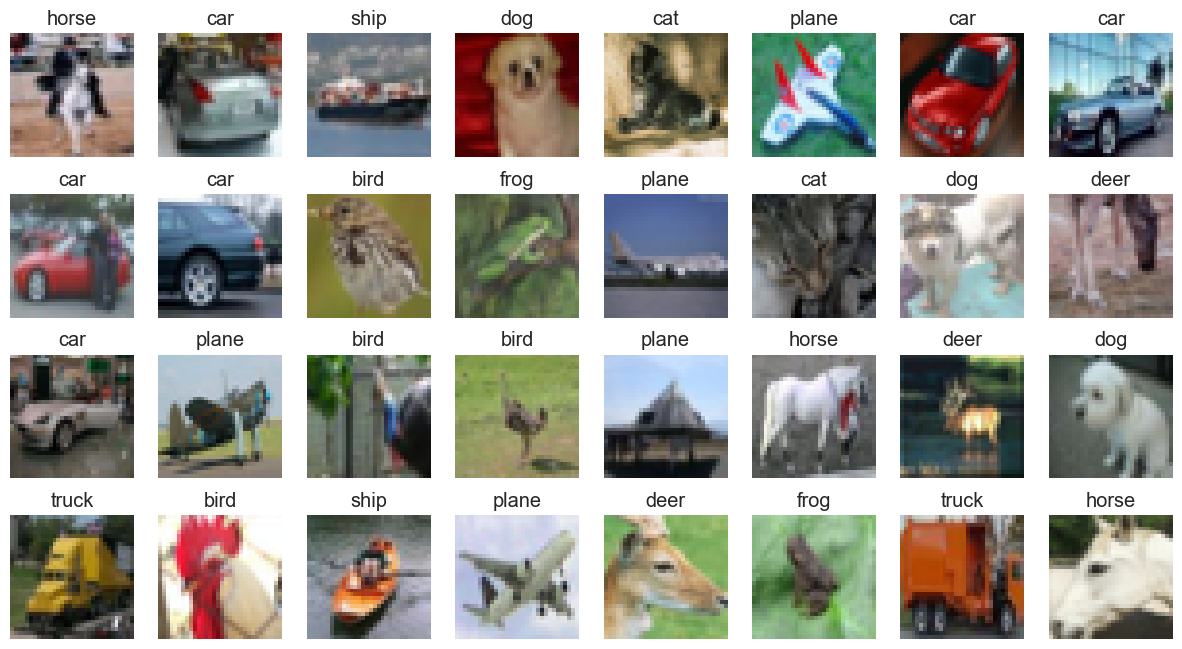

In [12]:
images, labels = next(iter(trainloader))

fig = plt.figure(figsize = (15,8))

for i in range(BATCH_SIZE):
    ax = fig.add_subplot(BATCH_SIZE // 8, 8, (i + 1), xticks = [], yticks = [])
    fn_imshow(images[i], ax = ax, normalize = True)
    ax.set_title(class_names[labels[i]])

In [13]:
testloader.dataset

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ..\input
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485 0.456 0.406], std=[0.229 0.224 0.225])
           )

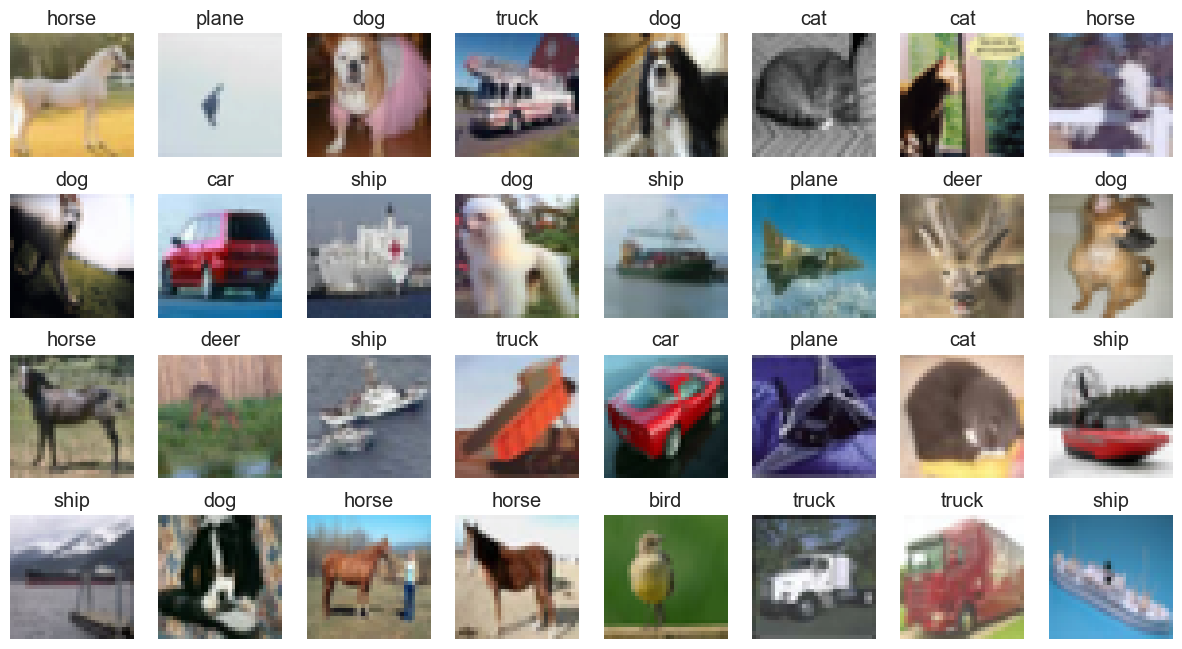

In [14]:
images, labels = next(iter(testloader))

fig = plt.figure(figsize = (15,8))

for i in range(BATCH_SIZE):
    ax = fig.add_subplot(BATCH_SIZE // 8, 8, (i + 1), xticks = [], yticks = [])
    fn_imshow(images[i], ax = ax, normalize = True)
    ax.set_title(class_names[labels[i]])

In [15]:
numChannels = 3

numClasses = len(class_names)

trainSteps = len(trainloader.dataset) // BATCH_SIZE

testSteps = len(testloader.dataset) // BATCH_SIZE

trainSteps, testSteps

(1562, 312)

### Define Model

In [16]:
class LeNet(nn.Module):
    def __init__(self, numChannels, classes):

    # call parent's constructor
        super(LeNet, self).__init__()
        
        # Dropouts
        dor1 = 0.1
        dor2 = 0.15
        dor3 = 0.2
        dor4 = 0.2
        dor5 = 0.25
        
        ## Define Layers
        ### Set 01 ###
        out_channels1 = 32
        
        # Conv ==> BN ==> LeakyRelu ==> Pool ==> Dropout 
        self.conv1 = nn.Conv2d(in_channels = numChannels, 
                               out_channels = out_channels1,
                               padding = 'same', 
                               kernel_size = (3,3))         # output_shape = 32 x 32 x 32
        
        self.bn1 = nn.BatchNorm2d(out_channels1)
        self.actv1 = nn.LeakyReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size = (2,2), stride = (2,2))     # output_shape = 16 x 16 x 32
        self.dropout1 = nn.Dropout(p = dor1)
        
        
        
        ### Set 02 ###
        out_channels2 = 64
        
        # Conv ==> BN ==> LeakyRelu ==> Pool ==> Dropout 
        self.conv2 = nn.Conv2d(in_channels = out_channels1, 
                               out_channels = out_channels2,
                               padding = 'same', 
                               kernel_size = (3,3))         # output_shape = 16 x 16 x 64
        
        self.bn2 = nn.BatchNorm2d(out_channels2)
        self.actv2 = nn.LeakyReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size = (2,2), stride = (2,2))     # output_shape = 8 x 8 x 64
        self.dropout2 = nn.Dropout(p = dor2)
        
        
        
        ### Set 03 ###
        out_channels3 = 128
        
        # Conv ==> BN ==> LeakyRelu ==> Pool ==> Dropout 
        self.conv3 = nn.Conv2d(in_channels = out_channels2, 
                               out_channels = out_channels3, 
                               kernel_size = (3,3))         # output_shape = 6 x 6 x 128
        
        self.bn3 = nn.BatchNorm2d(out_channels3)
        self.actv3 = nn.LeakyReLU()
        self.maxpool3 = nn.MaxPool2d(kernel_size = (2,2), stride = (2,2))     # output_shape = 3 x 3 x 128
        self.dropout3 = nn.Dropout(p = dor3)
        
        
        
        ### Set 04 ###
        out_channels4 = 256
        
        # Conv ==> BN ==> LeakyRelu ==> Pool ==> Dropout 
        self.conv4 = nn.Conv2d(in_channels = out_channels3, 
                               out_channels = out_channels4, 
                               kernel_size = (3,3))         # output_shape = 1 x 1 x 256
        
        self.bn4 = nn.BatchNorm2d(out_channels4)
        self.actv4 = nn.LeakyReLU()
        
        
        ############
        ### Head ###
        out_channels5 = 128
        
        # Conv ==> BN ==> LeakyRelu ==> Pool ==> Dropout 
        self.fc1 = nn.Linear(in_features = 1 * 1 * out_channels4, 
                               out_features = out_channels5)         # output_shape = 128
        self.bn5 = nn.BatchNorm1d(out_channels5)
        self.actv5 = nn.LeakyReLU()
        self.dropout5 = nn.Dropout(p = dor5)
        
        ### Final output layer
        self.fc2 = nn.Linear(in_features = out_channels5, 
                               out_features = classes)       # output_shape = 128
        self.logSoftmax = nn.LogSoftmax(dim = 1)
        
        
    def forward(self, x):
        
        # pass through 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.actv1(x)
        x = self.maxpool1(x)
        x = self.dropout1(x)
        
        # pass through 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.actv2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x)
        
        # pass through 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.actv3(x)
        x = self.maxpool3(x)
        x = self.dropout3(x)
        
        # pass through 4
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.actv4(x)
        
        x = torch.flatten(x, 1)
        
        # Head Fully Connected Layers
        x = self.fc1(x)
        x = self.bn5(x)
        x = self.actv5(x)
        x = self.dropout5(x)
        
        # Output
        x = self.fc2(x)
        return self.logSoftmax(x)

In [17]:
model = LeNet(numChannels = numChannels, classes = numClasses).to(device)
model = model.to(device)
print(model)

LeNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (actv1): LeakyReLU(negative_slope=0.01)
  (maxpool1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout1): Dropout(p=0.1, inplace=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (actv2): LeakyReLU(negative_slope=0.01)
  (maxpool2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (dropout2): Dropout(p=0.15, inplace=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (actv3): LeakyReLU(negative_slope=0.01)
  (maxpool3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  

In [18]:
summary(model, input_size = (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             896
       BatchNorm2d-2           [-1, 32, 32, 32]              64
         LeakyReLU-3           [-1, 32, 32, 32]               0
         MaxPool2d-4           [-1, 32, 16, 16]               0
           Dropout-5           [-1, 32, 16, 16]               0
            Conv2d-6           [-1, 64, 16, 16]          18,496
       BatchNorm2d-7           [-1, 64, 16, 16]             128
         LeakyReLU-8           [-1, 64, 16, 16]               0
         MaxPool2d-9             [-1, 64, 8, 8]               0
          Dropout-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 128, 6, 6]          73,856
      BatchNorm2d-12            [-1, 128, 6, 6]             256
        LeakyReLU-13            [-1, 128, 6, 6]               0
        MaxPool2d-14            [-1, 12

In [19]:
loss_fn = nn.CrossEntropyLoss()
opt = torch.optim.Adam(model.parameters(), lr = ALPHA)

H = {
    'epoch': [],
    'train_loss': [],
    'test_loss': [],
    'train_acc': [],
    'test_acc': [],
}

In [20]:
minLoss = np.inf

counter = 0

savePath = os.path.join(modelDir, subDir, altName+'.pth')

In [21]:
print(f'Number of parameter: {len(list(model.parameters()))}')

Number of parameter: 22


In [22]:
for epoch in range(EPOCHS):
    
    model.train() # set your model in train mode
    
    # Initialize
    totalTrainLoss = 0
    totalTestLoss = 0
    trainCorrect = 0
    testCorrect = 0
    
    for(train_X, train_y) in trainloader:
        
        train_X = train_X.to(device)
        train_y = train_y.to(device)
        
        pred = model(train_X)      # Make perdiction
    
        curr_loss = loss_fn(pred, train_y)     # Calculate loss
    
        ### Back Propogation 
        opt.zero_grad()
        curr_loss.backward()
        opt.step()
        totalTrainLoss += curr_loss
        trainCorrect += (pred.argmax(1) == train_y).type(torch.float).sum().item()
    
    with torch.no_grad():
        model.eval() # Do not update your weights
        
        for(test_X, test_y) in testloader:
        
            test_X = test_X.to(device)
            test_y = test_y.to(device)


            ts_pred = model(test_X)      # Make perdiction
            ts_curr_loss = loss_fn(ts_pred, test_y)

            totalTestLoss += ts_curr_loss
            testCorrect += (ts_pred.argmax(1) == test_y).type(torch.float).sum().item()
    
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps
    
    #### Add Early Stopping
    if avgTestLoss < minLoss:
        minLoss = avgTestLoss
        #torch.save({'epoch': epoch + 1,
                   # 'model_state_dict': model.state_dict(),
                   #'optimizer_state_dict': opt.state_dict(),
                   #'loss': loss_fn,},savePath)
        
    if avgTestLoss > minLoss:
        counter += 1
    if counter > PATIENCE:
        break
    
    #------------------------------
    trainCorrect = trainCorrect / len(trainloader.dataset)
    testCorrect = testCorrect / len(testloader.dataset)
    
    H['epoch'].append(epoch)
    H['train_loss'].append(avgTrainLoss.cpu().item())
    H['test_loss'].append(avgTestLoss.cpu().item())
    H['train_acc'].append(trainCorrect)
    H['test_acc'].append(testCorrect)
    
    # print the model training and validation information
    print(f"[INFO] EPOCH: {epoch + 1} / {EPOCHS}", end = ' ')
    print(f"Loss: {avgTrainLoss:.6f}, Accuracy: {trainCorrect:.4f};", end = ' ')
    print(f"Test loss: {avgTestLoss:.6f}, Test accuracy: {testCorrect:.4f}")

[INFO] EPOCH: 1 / 50 Loss: 1.274984, Accuracy: 0.5459; Test loss: 0.931916, Test accuracy: 0.6721
[INFO] EPOCH: 2 / 50 Loss: 0.972285, Accuracy: 0.6579; Test loss: 0.814321, Test accuracy: 0.7137
[INFO] EPOCH: 3 / 50 Loss: 0.848933, Accuracy: 0.7051; Test loss: 0.718386, Test accuracy: 0.7562
[INFO] EPOCH: 4 / 50 Loss: 0.770072, Accuracy: 0.7325; Test loss: 0.667161, Test accuracy: 0.7673
[INFO] EPOCH: 5 / 50 Loss: 0.708422, Accuracy: 0.7526; Test loss: 0.640745, Test accuracy: 0.7761
[INFO] EPOCH: 6 / 50 Loss: 0.660876, Accuracy: 0.7702; Test loss: 0.616517, Test accuracy: 0.7866
[INFO] EPOCH: 7 / 50 Loss: 0.618081, Accuracy: 0.7860; Test loss: 0.602558, Test accuracy: 0.7929
[INFO] EPOCH: 8 / 50 Loss: 0.583038, Accuracy: 0.7974; Test loss: 0.578867, Test accuracy: 0.8020
[INFO] EPOCH: 9 / 50 Loss: 0.553524, Accuracy: 0.8056; Test loss: 0.563190, Test accuracy: 0.8071
[INFO] EPOCH: 10 / 50 Loss: 0.526048, Accuracy: 0.8165; Test loss: 0.561179, Test accuracy: 0.8085
[INFO] EPOCH: 11 / 

In [23]:
loss_df = pd.DataFrame(H)
loss_df.head()

,epoch,train_loss,test_loss,train_acc,test_acc
0,0,1.27,0.93,0.55,0.67
1,1,0.97,0.81,0.66,0.71
2,2,0.85,0.72,0.71,0.76
3,3,0.77,0.67,0.73,0.77
4,4,0.71,0.64,0.75,0.78


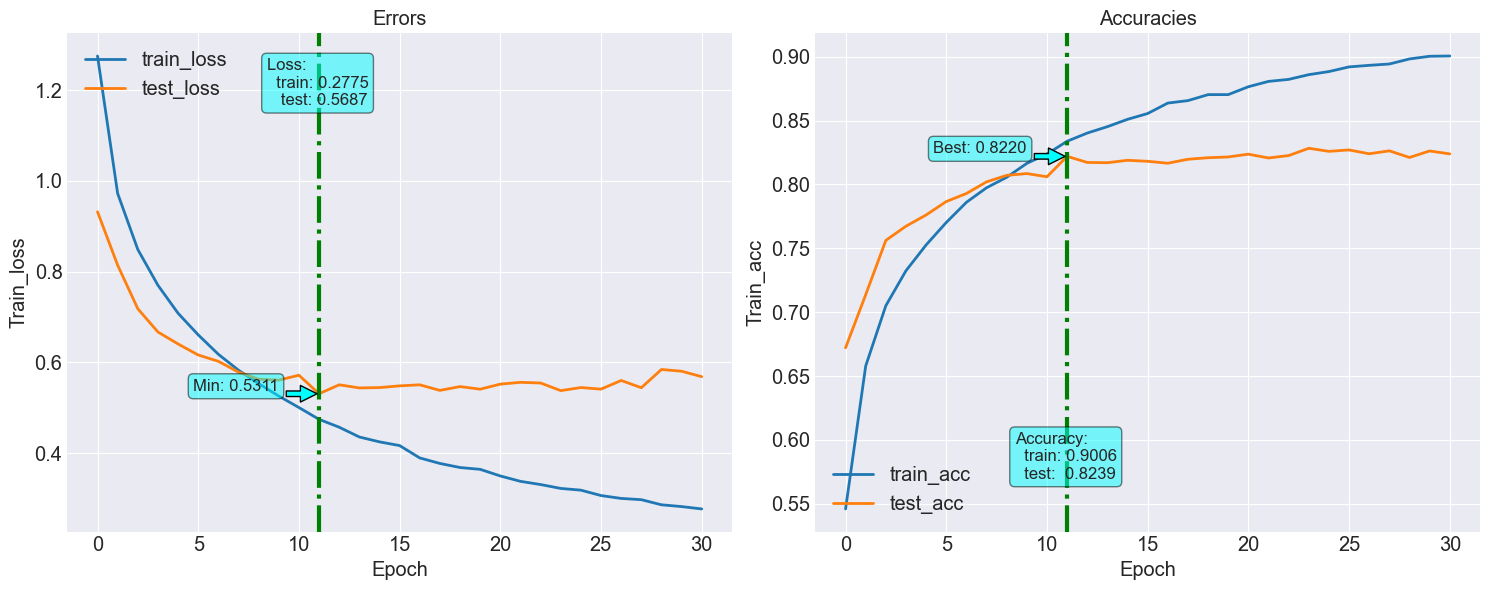

In [24]:
fn_plot_torch_hist(loss_df)

In [27]:
#model_dict = torch.load(savePath)
#model_dict.keys()

In [28]:
#model1 = LeNet(numChannels = numChannels, classes = numClasses).to(device)
#model1.load_state_dict(model_dict['model_state_dict'])

In [53]:
preds = []
labels = []

with torch.no_grad():
    model.eval()
    
    for (test_X, test_y) in testloader:
        test_X = test_X.to(device)
        test_y = test_y.to(device)
        
        ts_pred = model(test_X)
        preds.extend(ts_pred.argmax(axis = 1). cpu().numpy())
        labels.extend(test_y.cpu().numpy())

In [54]:
accuracy_score(np.array(labels), np.array(preds))

0.828

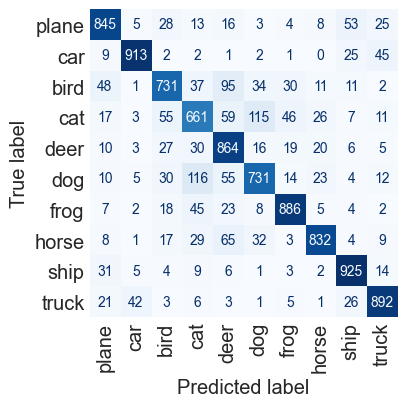

In [55]:
class_labels = {0: 'plane',1:  'car',2: 'bird',3: 'cat',4: 'deer',
               5: 'dog',6: 'frog',7: 'horse',8: 'ship',9: 'truck'}

fn_plot_confusion_matrix(np.array(labels), np.array(preds), class_labels)

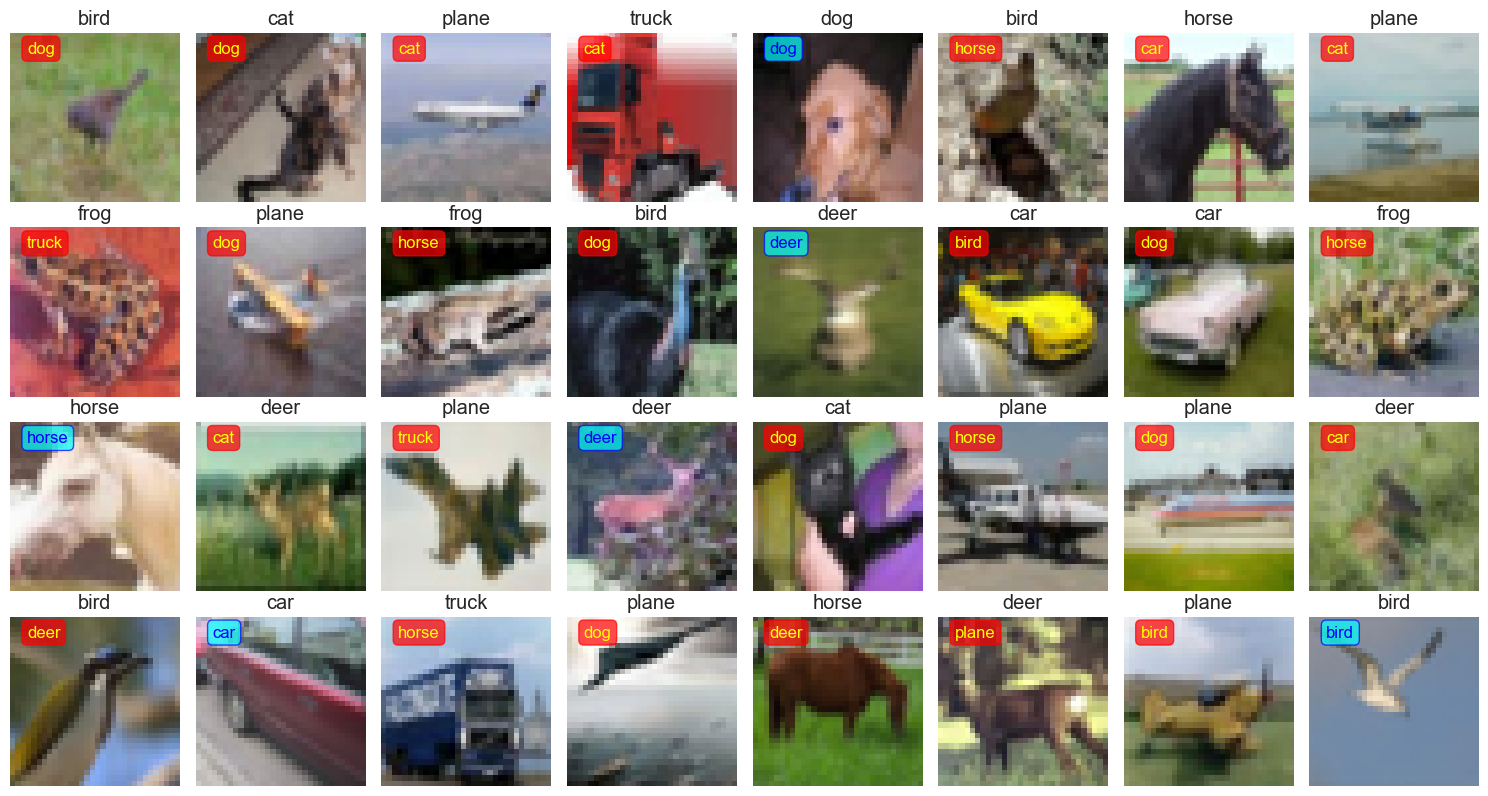

In [56]:
images, labels = next(iter(testloader))

images = images.to(device)
yhat = model1(images)

y_pred = yhat.argmax(axis = 1).cpu().detach().numpy()
labels = labels

fig = plt.figure(figsize = (15,8))

fig.subplots_adjust(left = 0.,
                    right = 1.,
                    bottom = 0.,
                    top = 1.,
                    hspace = 0.05,
                    wspace = 0.05,)
fontsize = 12

for i in range(BATCH_SIZE):
    
    fc = 'cyan'
    ec = 'blue'
    text_color = 'blue'
    
    if labels[i] != y_pred[i]:
        fc = 'red'
        ec = 'red'
        text_color = 'yellow'
        
    props = dict(boxstyle = 'round', facecolor = fc, alpha = 0.7, ec = ec)
    
    ax = fig.add_subplot(BATCH_SIZE // 8, 8, (i + 1), xticks = [], yticks = [])
    
    fn_imshow(images[i].cpu(), ax = ax, normalize = True)
    
    ax.text(0.1, 0.95, class_names[y_pred[i]], transform = ax.transAxes,
            fontsize = fontsize, color = text_color,
            verticalalignment = 'top', bbox = props)
    
    ax.set_title(class_names[labels[i]])
    
    ax.axis('off')
    
plt.tight_layout()
plt.show()